# AM 216 Final Project
Lihong Zhang, Litao Yan, Ruoxi Yang

Our final project is composed of 2 notebooks

We were inspired by the drug-protein affinity project in the mini projects, and do the final project in exploring the representations and models of drugs and proteins. 

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

In [2]:
import numpy as np
import rdkit
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles

import tensorflow as tf
from keras import Sequential, Model, Input
from keras.layers import Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from keras import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D

from spektral.layers import GATConv, ChebConv

import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from collections import OrderedDict
import networkx as nx

from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

import matplotlib.pyplot as plt
import json
import pickle
from collections import OrderedDict
import networkx as nx

import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

RDKit WARNING: [21:02:54] Enabling RDKit 2019.09.3 jupyter extensions


In [6]:
# This cell is from mini project
# for converting protein sequence to categorical format/numerical format
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:i for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000   # Note that all protein data will have the same length 1000 

def seq_to_cat(prot):  # prot: protein
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  



Read in Kiba data

In [8]:

# fpath = G_PATH + '/data_Drug_target_binding_affinity/data/kiba/'
fpath = LOCAL_PATH + '/data_Drug_target_binding_affinity/data/kiba/'

# Read in drugs and proteins
drugs_ = json.load(open(fpath + "ligands_can.txt"), object_pairs_hook=OrderedDict)
drugs = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in drugs_.values()])
proteins_ = json.load(open(fpath + "proteins.txt"), object_pairs_hook=OrderedDict)
proteins = np.array(list(proteins_.values()))

# Read in affinity data
affinity = np.array(pickle.load(open(fpath + "Y","rb"), encoding='latin1'))

# Read in train/test fold  
train_fold = json.load(open(fpath + "folds/train_fold_setting1.txt"))
train_fold = [ee for e in train_fold for ee in e ]    
'''
Here all validation folds are aggregated into training set. 
If you want to train models with different architectures and/or 
optimize for model hyperparameters, we encourage you to use 5-fold 
cross validation as provided here.
'''
test_fold = json.load(open(fpath + "folds/test_fold_setting1.txt"))

# Prepare train/test data with fold indices
rows, cols = np.where(np.isnan(affinity)==False) 
drugs_tr = drugs[rows[train_fold]]    # (98545,)
proteins_tr = np.array([seq_to_cat(p) for p in proteins[cols[train_fold]]])   # (98545, 1000)
affinity_tr = affinity[rows[train_fold], cols[train_fold]]  # (98545,)

drugs_ts = drugs[rows[test_fold]] # (19709,)
proteins_ts = np.array([seq_to_cat(p) for p in proteins[cols[test_fold]]]) # (19709, 1000)
affinity_ts = affinity[rows[test_fold], cols[test_fold]]    # (19709,)

In [9]:
print('Example of drug:{}'.format(drugs_tr[0]))
print('Example of protein:{} ...'.format(proteins_tr[0][:10]))
print('Example of affinity score:{}'.format(affinity_tr[0]))

Example of drug:O=C1c2c(c3c4ccc(O)cc4n(C4OC(CO)C(O)C(O)C4O)c3c3[nH]c4cc(O)ccc4c23)C(=O)N1NC(CO)CO
Example of protein:[11. 17.  0. 12. 12. 17. 14. 14. 17.  0.] ...
Example of affinity score:9.798970004000001


In [10]:
# Convert to ECFP fingerprint
smileToMol = lambda x: MolFromSmiles(x)  # molecules from smiles
featurizer = dc.feat.CircularFingerprint(size=1024)

drugs_mol_tr = list(map(smileToMol, drugs_tr))
drugs_ecfp_tr = featurizer.featurize(drugs_mol_tr)
drugs_mol_ts = list(map(smileToMol, drugs_ts))
drugs_ecfp_ts = featurizer.featurize(drugs_mol_ts)

print(drugs_ecfp_tr.shape)
print(drugs_ecfp_ts.shape)

(98545, 1024)
(19709, 1024)


In [37]:
# Save to local computer
np.savetxt(LOCAL_PATH + '/saved_data_local/drugs_ecfp_tr.csv', drugs_ecfp_tr, delimiter= ',')
np.savetxt(LOCAL_PATH + '/saved_data_local/drugs_ecfp_ts.csv', drugs_ecfp_ts, delimiter= ',')

In [ ]:
# Read drugs_edfp from the saved files
drugs_ecfp_ts = np.loadtxt(G_PATH + '/saved_data_drive/drugs_ecfp_ts.csv', delimiter = ',')
drugs_ecfp_tr = np.loadtxt(G_PATH + '/saved_data_drive/drugs_ecfp_tr.csv', delimiter = ',')

In [11]:
tr_size, drug_size = drugs_ecfp_tr.shape[0], drugs_ecfp_tr.shape[1]
ts_size = drugs_ecfp_ts.shape[0]

protein_size = max_seq_len

## 3. Train a model on KIBA data


### 3.1 Baseline Model


#### (1) Model description:
Here we first try a naive baseline prediction model that comprises two blocks, each of which aims to learn representations from SMILES strings and protein sequences. For each we used a FC layer to learn the representation of input data, since Fully-Connected Neural Networks are popular models for baseline. The final features layers were concatenated and fed into three FC layers, which is the DeepDTA, adopted from the paper “DeepDTA: deep drug–target binding affinity prediction”. Specifically, we used 1024 nodes in the first two FC layers, each followed by a dropout layer of rate 0.1 to avoid over-fitting. And the third layer consisted of 512 nodes and was followed by the output layer. Below is the summary of the model architecture. We also used Adam as the optimizer and MSE as the loss function.


In [ ]:
# Have fun!
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense, concatenate, Dropout

def build_baseline_model(drug_size, protein_size):

  drug_model = Sequential()
  drug_model.add(Dense(1, input_shape=(drug_size,), activation='linear'))

  protein_model = Sequential()
  protein_model.add(Dense(1, input_shape=(protein_size,), activation='linear'))

  # concat_layer = tf.keras.layers.Concatenate([drug_model.outputs[0], protein_model.outputs[0]])
  model_concat = concatenate([drug_model.output, protein_model.output])
  
  # fully connected
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(512, activation='relu')(model_concat)
  model_concat = Dense(1, kernel_initializer='normal')(model_concat)
  
  model = Model(inputs=[drug_model.input, protein_model.input], outputs=model_concat)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
  
  return model

model = build_baseline_model(drug_size=drug_size, protein_size=protein_size)
print(model.summary())

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 100
batch_size = 50

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_history = model.fit([drugs_ecfp_tr, proteins_tr], affinity_tr, 
                    validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=True)


Train on 78836 samples, validate on 19709 samples
Epoch 1/100
78836/78836 [==============================] - 68s 865us/step - loss: 0.5321 - mean_squared_error: 0.5321 - val_loss: 2.0868 - val_mean_squared_error: 2.0868
Epoch 2/100
78836/78836 [==============================] - 69s 873us/step - loss: 0.5283 - mean_squared_error: 0.5283 - val_loss: 2.1565 - val_mean_squared_error: 2.1565
Epoch 3/100
78836/78836 [==============================] - 67s 853us/step - loss: 0.5310 - mean_squared_error: 0.5310 - val_loss: 1.2997 - val_mean_squared_error: 1.2997
Epoch 4/100
78836/78836 [==============================] - 66s 838us/step - loss: 0.5190 - mean_squared_error: 0.5190 - val_loss: 1.6997 - val_mean_squared_error: 1.6997
Epoch 5/100
78836/78836 [==============================] - 67s 844us/step - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 1.7902 - val_mean_squared_error: 1.7902
Epoch 6/100
78836/78836 [==============================] - 67s 855us/step - loss: 0.5030 - mean_squa

KeyboardInterrupt: ignored

In [ ]:

print("Evaluate on test data")
results = model.evaluate([drugs_ecfp_ts, proteins_ts], affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
19709/19709 [==============================] - 2s 105us/step
test MSE loss is: [0.398003730737514, 0.3980037271976471]


In [ ]:
predicted_affinity = model.predict([drugs_ecfp_ts, proteins_ts])

In [ ]:
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

test CI score is: 0.7536044611424282


#### (2) Result:
Training the model for 10 epochs, we tested the trained model on the test dataset. The model achieves the MSE of 0.398 and CI score of 0.754, which is slightly lower than the model presented in the original paper. 


### 3.2 Train a CNN model on KIBA Data
Drugs and protein are represented by 1-D vectors, which represent their structures in the numerical way. Whether a drug-protein binding has a high affinity score depends on whether the drug and protein have matching structures, especially the geometrical structures. CNN is a good method to identify geometrical shapes, thus we can use it to extract the geometrical characterstics of drugs and proteins, and predict the affinity score. To match the dimensions of drug and proteins vectors, we use 1D CNN here.

The idea of CNN model is also from the paper "DeepDTA: deep drug–target binding affinity prediction"(https://academic.oup.com/bioinformatics/article/34/17/i821/5093245). For the structure of the CNN model, since drugs and proteins are two different inputs, it doesn't make sense to concatenate them together and use the concatenation as an input. So we use two CNN models ```drug_cnn``` and ```prot_cnn``` to take drugs and proteins as inputs respectively, and concatenate the outputs of these 2 CNN models to a new embedding, which is the input to the third CNN model ```cnn_concat```, then get the final CNN model ```cnn```. We also used the dropout layer to avoid overfitting and the dense layer to get the final result.

The implementation and evaluation of the CNN model is as below.

In [12]:
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten

#### (1) Prepare data for CNN

In [13]:

num_train, num_drugs = drugs_ecfp_tr.shape
num_prot = proteins_tr.shape[1]
drugs_tr_reshape = drugs_ecfp_tr.reshape((num_train, num_drugs, 1))
proteins_tr_reshape = proteins_tr.reshape((num_train, num_prot, 1))

# Testing data
drug_ts_reshape = drugs_ecfp_ts.reshape((drugs_ecfp_ts.shape[0], drugs_ecfp_ts.shape[1], 1))
proteins_ts_reshape = proteins_ts.reshape((proteins_ts.shape[0], proteins_ts.shape[1], 1))

#### (2) Build and Train a CNN model

In [24]:
# CNN for protein
cnn_input = Input(shape=(num_prot,1))
cnn_layer = Conv1D(16, 3, activation='relu', input_shape=(num_prot, 1))(cnn_input)
cnn_layer = MaxPooling1D(3)(Feat_layer)
cnn_layer = Flatten()(Feat_layer)
cnn_layer = Dropout(0.1)(Feat_layer)
cnn_layer = Dense(16, activation = 'linear')(Feat_layer)

# xs1, xs2 = nodes_ts_davis.shape[1], nodes_ts_davis.shape[2]
# as1, as2 = adj_tr_davis.shape[1], adj_tr_davis.shape[2]
X_in = Input(shape=(num_drugs, 1))
A_in = Input(shape = (num_drugs, 1))

# GNN for 
graph_conv = ChebConv(64, activation='relu',name='graph_input', kernel_regularizer='l1')([X_in, A_in])
graph_conv = Dropout(0.1)(graph_conv)

graph_conv = ChebConv(32, activation='relu', kernel_regularizer='l1')([graph_conv,A_in])

graph_conv = Dropout(0.1)(graph_conv)

# graph_conv = GATConv(64, activation='relu')([graph_conv,A_in])
# graph_conv = Dropout(0.5)(graph_conv)
graph_conv = ChebConv(32, activation='relu')([graph_conv, A_in])

graph_conv = Flatten()(graph_conv)
graph_conv = Dense(16, activation= 'linear')(graph_conv)

dta_concat = concatenate([graph_conv, cnn_layer])

dta_concat = Dense(512, activation='relu')(dta_concat)
dta_concat = Dense(16, activation='relu')(dta_concat)
dta_concat = Dense(1, activation='softmax')(dta_concat)

model = Model(inputs={'graph_input':[X_in, A_in], 'cnn_input':Feat_input}, outputs=dta_concat)



model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
graph_input (ChebConv)          (None, 1024, 64)     128         input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 1024, 64)     0           graph_input[0][0]          

In [26]:
history = model.fit({'graph_input': [drugs_tr_reshape, drugs_tr_reshape], 'cnn_input': proteins_tr_reshape }, affinity_tr,batch_size=28, epochs=50,steps_per_epoch=10)

Epoch 1/50
10/10 [==============================] - 0s 40ms/step - loss: 113.6521 - mean_squared_error: 113.6494
Epoch 2/50
10/10 [==============================] - 0s 41ms/step - loss: 117.1486 - mean_squared_error: 117.1460
Epoch 3/50
10/10 [==============================] - 0s 39ms/step - loss: 114.6067 - mean_squared_error: 114.6040
Epoch 4/50
10/10 [==============================] - 0s 41ms/step - loss: 115.3370 - mean_squared_error: 115.3343
Epoch 5/50
10/10 [==============================] - 0s 36ms/step - loss: 117.3228 - mean_squared_error: 117.3201
Epoch 6/50
10/10 [==============================] - 0s 44ms/step - loss: 117.1956 - mean_squared_error: 117.1930
Epoch 7/50
10/10 [==============================] - 0s 43ms/step - loss: 116.0070 - mean_squared_error: 116.0043
Epoch 8/50
10/10 [==============================] - 0s 44ms/step - loss: 115.5088 - mean_squared_error: 115.5062
Epoch 9/50
10/10 [==============================] - 0s 38ms/step - loss: 115.4834 - mean_squared

In [32]:
drug_ts_reshape = drugs_ecfp_ts.reshape((drugs_ecfp_ts.shape[0], drugs_ecfp_ts.shape[1], 1))
proteins_ts_reshape = proteins_ts.reshape((proteins_ts.shape[0], proteins_ts.shape[1], 1))
print("Evaluate on test data")
results = model.evaluate({'graph_input': [drug_ts_reshape, drug_ts_reshape], 'cnn_input': proteins_ts_reshape }, affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
154/154 [==============================] - 5s 27ms/step - loss: 115.5841 - mean_squared_error: 115.5814
test MSE loss is: [115.58409881591797, 115.5813980102539]


In [35]:
predicted_affinity = model.predict({'graph_input': [drug_ts_reshape, drug_ts_reshape], 'cnn_input': proteins_ts_reshape })
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

KeyboardInterrupt: 

In [ ]:
# CNN 
from keras import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten

def sub_cnn(input_dim):
    cnn = Sequential() # Create sequential model
    cnn.add(Conv1D(16, 3, activation='relu', input_shape=(input_dim, 1)))
    cnn.add(MaxPooling1D(3))
    cnn.add(Flatten())
    cnn.add(Dropout(0.1))
    cnn.add(Dense(16, activation = 'linear'))
    return cnn
drug_cnn = sub_cnn(num_drugs)
prot_cnn = sub_cnn(num_prot)
cnn_concat = concatenate([drug_cnn.output, prot_cnn.output])

'''
cnn_drug = Sequential() # Create sequential model
cnn_drug.add(Conv1D(16, 3, activation='relu', input_shape=(num_drugs, 1)))
cnn.add(MaxPooling1D(3))

cnn_prot = Sequential()
cnn_prot.add(Conv1D(16, 3, activation='relu', input_shape=(num_prot, 1)))
cnn.add(MaxPooling1D(3))
# Concatenate
cnn = concatenate([cnn_drug.output, cnn_prot.output])
'''

cnn_concat = Dense(1024, activation='relu')(cnn_concat)
cnn_concat = Dropout(0.1)(cnn_concat)
cnn_concat = Dense(16, activation='relu')(cnn_concat)

cnn_concat = Dense(1, activation='linear')(cnn_concat)

cnn = Model(inputs=[drug_cnn.input, prot_cnn.input], outputs=cnn_concat)
# Show model summary
cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_3_input (InputLayer)     (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
conv1d_4_input (InputLayer)     (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1022, 16)     64          conv1d_3_input[0][0]             
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 16)      64          conv1d_4_input[0][0]             
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 100
batch_size = 256

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
train_history = cnn.fit([drugs_tr_reshape, proteins_tr_reshape], affinity_tr, 
                    validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=True)


Train on 78836 samples, validate on 19709 samples
Epoch 1/100
78836/78836 [==============================] - 66s 834us/step - loss: 2.6518 - mean_squared_error: 2.6518 - val_loss: 0.4968 - val_mean_squared_error: 0.4968
Epoch 2/100
78836/78836 [==============================] - 65s 821us/step - loss: 0.6922 - mean_squared_error: 0.6922 - val_loss: 0.5036 - val_mean_squared_error: 0.5036
Epoch 3/100
78836/78836 [==============================] - 64s 818us/step - loss: 0.6023 - mean_squared_error: 0.6023 - val_loss: 0.4733 - val_mean_squared_error: 0.4733
Epoch 4/100
78836/78836 [==============================] - 64s 815us/step - loss: 0.5789 - mean_squared_error: 0.5789 - val_loss: 0.4322 - val_mean_squared_error: 0.4322
Epoch 5/100
78836/78836 [==============================] - 64s 812us/step - loss: 0.5364 - mean_squared_error: 0.5364 - val_loss: 0.4204 - val_mean_squared_error: 0.4204
Epoch 6/100
78836/78836 [==============================] - 64s 813us/step - loss: 0.5053 - mean_squ

#### (3) Evaluate the CNN model

In [ ]:
drug_ts_reshape = drugs_ecfp_ts.reshape((drugs_ecfp_ts.shape[0], drugs_ecfp_ts.shape[1], 1))
proteins_ts_reshape = proteins_ts.reshape((proteins_ts.shape[0], proteins_ts.shape[1], 1))
print("Evaluate on test data")
results = cnn.evaluate([drug_ts_reshape, proteins_ts_reshape], affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
19709/19709 [==============================] - 6s 301us/step
test MSE loss is: [0.21053694547722707, 0.21053697168827057]


In [ ]:
predicted_affinity = cnn.predict([drug_ts_reshape, proteins_ts_reshape])
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

test CI score is: 0.8394054274277895


[The original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4364066/) obtained CI score of 0.782 and MSE of 0.411, and [random forest model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/) got 0.836 and 0.222. Can you beat them?

The CNN models has MSE = 0.21053694547722707, and CI score = 0.8394054274277895 on the test set. 
Both the MSE value and the CI score of the CNN model beat the above baseline model, the original paper, and the random forest model. It's possibly because that CNN models can extract the underlying characteristics of drugs and proteins better than the Kronecker RLS method used in the original paper. 

The performance is just a little better than that of the random forest model, but we haven't use the cross validation which was used in the paper for model selection. Let's use cross validation and see if it would improve the performance.


#### (4) Cross Validation on CNN

Since a CNN model has so many parameters, it's hard to get the best value of each parameter by cross validation, but we can get the final prediction results by averaging the predicitons from each fold's model. Although some cross validation uses training data and testing data as a whole dataset for data splitting, here we do not touch testing data while training the models. We do 5-fold cross validation on the training data set, and do prediciton and model evaluation on the test data set. 

In the model training below, we do not set validation_split parameter, i.e. validation_split = 0. So the cross validaiton here is more like training data with 5 different validation sets, and the test indices from the ```kfold.split()``` function work as the validation indices.

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
import os
import pickle

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
epochs = 80
batch_size = 256

def sub_cnn(input_dim):
    cnn = Sequential() # Create sequential model
    cnn.add(Conv1D(16, 3, activation='relu', input_shape=(input_dim, 1)))
    cnn.add(MaxPooling1D(3))
    cnn.add(Flatten())
    cnn.add(Dropout(0.1))
    cnn.add(Dense(16, activation = 'linear'))
    return cnn

def cnn(i, x, y): 
  drug_cnn = sub_cnn(num_drugs)
  prot_cnn = sub_cnn(num_prot)
  cnn_concat = concatenate([drug_cnn.output, prot_cnn.output])
  cnn_concat = Dense(1024, activation='relu')(cnn_concat)
  cnn_concat = Dropout(0.1)(cnn_concat)
  cnn_concat = Dense(16, activation='relu')(cnn_concat)

  cnn_concat = Dense(1, activation='linear')(cnn_concat)

  cnn = Model(inputs=[drug_cnn.input, prot_cnn.input], outputs=cnn_concat)
  # Show model summary
  cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


  callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  train_history = cnn.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=True)
  # save the trained model for later use
  
  save_folder = f'{G_PATH}/saved_models/'
  os.makedirs(save_folder, exist_ok=True)
  save_path = save_folder + 'cnn_model_fold_{}'.format(i)
  cnn.save(save_path)
  print('model_{} saved'.format(i))
  return cnn

i = 1
models = []
cv_mse = []
MSE = []
cis = []
for train, test in kfold.split(drugs_tr_reshape, affinity_tr):
  # Define the model architecture
  x = [drugs_tr_reshape[train], proteins_tr_reshape[train]]
  y = affinity_tr[train]
  model = cnn(i, x, y)
  
  scores = model.evaluate([drugs_tr_reshape[test], proteins_tr_reshape[test]], affinity_tr[test], verbose=0)
  cv_mse.append(scores[1])
  print("Evaluate on test data by model {}".format(i))
  results = model.evaluate([drug_ts_reshape, proteins_ts_reshape], affinity_ts, batch_size=128)
  MSE.append(results[1])
  print("test MSE loss is:", results)
  predicted_affinity = model.predict([drug_ts_reshape, proteins_ts_reshape])
  ci_score = ci(affinity_ts, predicted_affinity)
  print('test CI score is:', ci_score)
  cis.append(ci_score)
  i += 1

save_folder = f'{G_PATH}/saved_results/'
with open(save_folder + "cv_mse.txt", "wb") as f:
  pickle.dump(cv_mse, f)
with open(save_folder + 'MSE.txt', 'wb') as f:
  pickle.dump(MSE, f)
with open(save_folder + 'CI.txt', 'wb') as f:
  pickle.dump(cis, f)


Epoch 1/80
78836/78836 [==============================] - 35s 444us/step - loss: 2.4288 - mean_squared_error: 2.4288
Epoch 2/80
78836/78836 [==============================] - 34s 437us/step - loss: 0.6623 - mean_squared_error: 0.6623
Epoch 3/80
78836/78836 [==============================] - 35s 440us/step - loss: 0.5858 - mean_squared_error: 0.5858
Epoch 4/80
78836/78836 [==============================] - 34s 436us/step - loss: 0.5541 - mean_squared_error: 0.5541
Epoch 5/80
78836/78836 [==============================] - 35s 438us/step - loss: 0.5193 - mean_squared_error: 0.5193
Epoch 6/80
78836/78836 [==============================] - 34s 436us/step - loss: 0.4930 - mean_squared_error: 0.4930
Epoch 7/80
78836/78836 [==============================] - 34s 435us/step - loss: 0.4862 - mean_squared_error: 0.4862
Epoch 8/80
78836/78836 [==============================] - 35s 440us/step - loss: 0.4784 - mean_squared_error: 0.4784
Epoch 9/80
78836/78836 [==============================] - 35s 43

In [ ]:
import numpy as np
import pickle

save_folder = f'{G_PATH}/saved_results/'
with open(save_folder + "cv_mse.txt", "rb") as f:
  cv_mse = pickle.load(f)
with open(save_folder + "MSE.txt", "rb") as f:
  MSE = pickle.load(f)
with open(save_folder + "CI.txt", "rb") as f:
  cis = pickle.load(f)
print("test MSE loss is:", np.mean(MSE))
print('test CI score is:', np.mean(cis))

test MSE loss is: 0.21358680427074433
test CI score is: 0.8337713494290373


#### (5) Result
The CNN model with cross validation gives almost same MSE and CI score on the test set as the original CNN model. The reason may be that CNN already extracts the characteristics of drugs and proteins very well, so there is not much improvement that cross validation can do. 

Considering that cross validation takes long training time, we recommend using CNN model without cross validation in practice. 

## 4. Use  your model on COVID-19 protease

Now, use your trained model to identify drugs that could be used as COVID-19 protease inhibitors from these 2111 drugs in the dataset. The sequence of the protease is provided in `6Y84_A.fasta.txt`. You might want to first predict a binding affinity of Ritonavior, a well known HIV drug that binds to HIV protease, to get the sense of a good binding score for this task. SMILES of Ritonavior is provided below.  

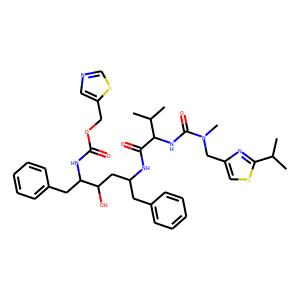

In [ ]:
ritonavior = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
rit_mol = MolFromSmiles(ritonavior)
Draw.MolToImage(rit_mol)

In [ ]:
rit = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(ritonavior),isomericSmiles=True)])
rit

array(['CC(C)c1nc(CN(C)C(=O)NC(C(=O)NC(Cc2ccccc2)CC(O)C(Cc2ccccc2)NC(=O)OCc2cncs2)C(C)C)cs1'],
      dtype='<U83')

Please keep in mind that proteins in KIBA data are kinase family, a different kind from protease. So in this exercise, we are relying on transfer learning. That is, the learned embedding for predicting kinase could be useful for predicting protease binding as well.

In [ ]:
protease = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"
protease_tr = np.array([seq_to_cat(protease)])

In [ ]:
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)

rit_mol = list(map(smileToMol, rit))
rit_ecfp = featurizer.featurize(rit_mol)

print(rit_ecfp.shape, protease_tr.shape)

(1, 1024) (1, 1000)


### Prediction by the baseline model



In [ ]:
path = './drive/MyDrive/Colab Notebooks/data_Drug_target_binding_affinity/baseline_model'
model = tf.keras.models.load_model(path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
target = model.predict([rit_ecfp, protease_tr])[0][0]
print(target)

11.488001


In [ ]:
pred_drug = ritonavior
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)
for drug in drugs:
  drug_smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(drug),isomericSmiles=True)])
  drug_mol = list(map(smileToMol, drug_smiles))
  drug_ecfp = featurizer.featurize(drug_mol)
  score = model.predict([drug_ecfp, protease_tr])[0][0]
  if score>target:
    print(drug, score)
    target = score
    pred_drug = drug
print(pred_drug, target)

O=C(Cc1ccccc1)Nc1cccc(-c2nc3sccn3c2-c2ccnc(Nc3cccc(N4CCOCC4)c3)n2)c1 11.586634
CNc1cncc(-c2c[nH]c(=O)c(NC(=O)c3ccc(N4CCCC4CN4CCCC4)cc3)c2)n1 11.786759
CN(c1ncccc1CNc1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1C(F)(F)F)S(C)(=O)=O 12.052496
COc1cc(Nc2ncc([N+](=O)[O-])c(Nc3ccccc3C(N)=O)n2)cc(OC)c1OC 12.538106
CN(C)C1CCCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)C1 12.572794
FC(F)(F)c1cccc(CNc2cc(-c3c[nH]c4ncccc34)ncn2)c1 12.776003
Clc1cc(-c2c[nH]c3ncccc23)nc(NC2CCOCC2)n1 12.80786
Cn1cc(Nc2ncc(Cl)c(Nc3ccccc3C(N)=O)n2)cn1 12.933596
CCNC(=O)NC1CCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)CC1 13.015325
Cn1cc(Nc2ncc(Br)c(Nc3ccccc3C(N)=O)n2)cn1 13.150837
CNCC(=O)NC1CCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)CC1 13.20871
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 13.486596
Cc1cc(O)cc2oc(=O)c3c(O)cc(OS(=O)(=O)O)cc3c12 13.762829
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4 14.24049
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4 14.24049


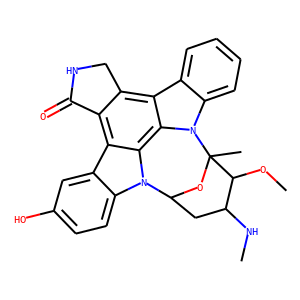

In [ ]:
best_mol = MolFromSmiles("CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4")
Draw.MolToImage(best_mol)

The drug with the highest binding affinity is CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4. And the affinity of this drug to the COVID-19 protease is $14.24049$



### Prediction by the CNN Model

In [ ]:
num_train, num_drugs = rit_ecfp.shape
num_prot = protease_tr.shape[1]
rit_ecfp = rit_ecfp.reshape((num_train, num_drugs, 1))
protease_tr_reshape = protease_tr.reshape((num_train, num_prot, 1))
print(rit_ecfp.shape, protease_tr_reshape.shape)

(1, 1024, 1) (1, 1000, 1)


In [ ]:
path = './drive/MyDrive/Colab Notebooks/data_Drug_target_binding_affinity/cnn_model'
model = tf.keras.models.load_model(path)

In [ ]:
target = model.predict([rit_ecfp, protease_tr_reshape])[0][0]
print(target)

12.476215


In [ ]:
pred_drug = ritonavior
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)
for drug in drugs:
  drug_smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(drug),isomericSmiles=True)])
  drug_mol = list(map(smileToMol, drug_smiles))
  drug_ecfp = featurizer.featurize(drug_mol)
  drug_ecfp = drug_ecfp.reshape((num_train, num_drugs, 1))
  score = model.predict([drug_ecfp, protease_tr_reshape])[0][0]
  if score>target:
    print(drug, score)
    target = score
    pred_drug = drug
print(pred_drug, target)

COc1cc(Nc2ncc([N+](=O)[O-])c(Nc3ccccc3C(N)=O)n2)cc(OC)c1OC 12.898549
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4cccc(OC(F)(F)F)c4)c3)cc12 13.369903
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4cccc(Cl)c4)c3)cc12 13.8015175
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccc(Cl)c(Cl)c4)c3)cc12 13.81483
Cn1cc(Nc2ncc(Br)c(Nc3ccccc3C(N)=O)n2)cn1 13.887487
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 14.350755
COc1cc(O)c2c(c1)C1(OC2=O)C(C)=CC(=O)C1O 14.415564
COc1cc(O)c2c(c1)C(=O)c1cc(C)c(O)cc1C2=O 14.471263
Cc1cc(O)cc2oc(=O)c3c(O)cc(OS(=O)(=O)O)cc3c12 14.578851
COc1cc(O)c2c(=O)oc3cc(O)cc(C)c3c2c1 14.655168
COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1 14.964367
COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1 14.964367


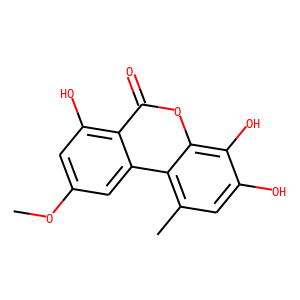

In [ ]:
best_mol = MolFromSmiles("COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1")
Draw.MolToImage(best_mol)

When using pretrained CNN model, The drug with the highest binding affinity is COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1. And the affinity of this drug to the COVID-19 protease is $14.96436$. The result is different from the baseline model. 

A possible reason for the differences between the baseline model and CNN model is the baseline model and CNN extract different characteristics of drugs and proteins. So they have different prediction results for the same protease. It also indicates that loss and accuracy should not be the only evaluation metric in the drug-binding research.

In order to better accomplish the goal of drug binding tasks, we suggest to consider adding other metrics, such as molecular biology and pharmacokinetics and other related knowledge.